In [1]:
%%capture

import math
import numpy as np
import pandas as pd
import sklearn as sk
import itertools as it

import matplotlib.pyplot as plt

import parmed as pmd
import mdtraj as md

from rdkit import Chem
from rdkit.Chem import AllChem, rdFMCS, PandasTools
from rdkit.Chem.EnumerateStereoisomers import EnumerateStereoisomers, StereoEnumerationOptions

from Bio.PDB import PDBList

from pdbfixer import *

from simtk.openmm.app import *
from simtk.openmm import *
from simtk.unit import *

from openforcefield.topology import Molecule, Topology
from openmmforcefields.generators import GAFFTemplateGenerator
from openforcefield.typing.engines.smirnoff import ForceField

def expmut(wt=[], mt=[]):
    return np.array([(x, y) for x in np.repeat(mt, len(wt)) for y in wt])
# def expandgrid(*itrs):
#    prod = 
#    return {'{}'.format(i+1):[x[i] for x in list(itertools.product(*itrs))] for i in range(len(itrs))}

In [2]:
AA19_CATS = {
    'Aliphatic': [
        'glycine','isoleucine','leucine','proline'], 
    'Aromatic': [
        'tryptophan','tyrosine','phenylalanine','histidine'],
    'Basic': [
        'histidine','lysine','arginine'],
    'Acidic': [
        'glutamine','asparagine'],
    'Hydroxylic': [
        'threonine', 'serine'],
    'Sulphur': [
        'methionine', 'cysteine'],
    'Amidic ': [
        'glutamine', 'asparagine']
}

AA19_CODES = pd.DataFrame([
    ('Phenylalanine','Phe','F'),
    ('Leucine','Leu','L'),
    ('Serine','Ser','S'),
    ('Tyrosine','Tyr','Y'),
    ('Cysteine','Cys','C'),
    ('Leucine','Leu','L'),
    ('Proline','Pro','P'),
    ('Histidine','His','H'),
    ('Glutamine','Gln','Q'),
    ('Isoleucine','Ile','I'),
    ('Methionine','Met','M'),
    ('Threonine','Thr','T'),
    ('Asparagine','Asn','N'),
    ('Lysine','Lys','K'),
    ('Serine','Ser','S'),
    ('Arginine','Arg','R'),
    ('Valine','Val','V'),
    ('Aspartate','Asp','D'),
    ('Glutamate','Glu','E'),
    ('Glycine','Gly','G')
], columns=['Full', 'Residue', 'Letter'])

In [3]:
PLATFORM = 'CPU'
CUDA_DEV_IDX = None

SCFV_IDS = ['1mfa']

PDB_DIR = 'structures/pdb/'
PDB_SLUG = PDB_DIR + 'pdb'

LIG_SDF = 'structures/sdf/Structure2D_CID_2978.sdf'
LIGAND_OFFSET = (0.0, 0.0, 0.0)

STEP_SIZE = 1000
TOTAL_STEPS = 10000
SIM_DURATION = TOTAL_STEPS*STEP_SIZE

N_TOTAL_RENDERS = 10
RENDER_INTERVAL = SIM_DURATION / N_TOTAL_RENDERS

ENERGY_TOLERANCE = 2
MAX_ENERGY_ITERS = 5000

LANGE_TOLERANCE = 10**-5
LANGE_TEMPERATURE = 302.0*kelvin
LANGE_FRICTION = 1.0/picoseconds
LANGE_STEPSIZE = 2.0*femtoseconds

REPORT_SLUG = '1MFA-2978'
PDB_FRAME_DIR = REPORT_SLUG + '.frames'
PDB_REPORT_FILE = REPORT_SLUG + '.pdb'
DCD_REPORT_FILE = REPORT_SLUG + '.dcd'
STATE_REPORT_FILE = REPORT_SLUG + '.state.txt'

RESTART_FILE = REPORT_SLUG + '.rst7'
STATE_RESTART_FILE = REPORT_SLUG + '.xml'
CHECKPOINT_RESTART_FILE = REPORT_SLUG + '.chk'

if not PLATFORM:
    PLATFORM = openmm.Platform.getPlatformByName(PLATFORM) 
else:
    PLATFORM = 'CPU'

if PLATFORM == 'CUDA':
    platprop = {
        'CudaPrecision': 'mixed', 
        'CudaDeviceIndex': (CUDA_DEV_IDX if CUDA_DEV_IDX else 0)} 

REPORTERS = [
    PDBReporter(PDB_REPORT_FILE, N_TOTAL_RENDERS),
    StateDataReporter(
        file=STATE_REPORT_FILE, 
        reportInterval=RENDER_INTERVAL, 
        progress=True, temperature=True, 
        potentialEnergy=True, density=True,
        totalSteps=TOTAL_STEPS, speed=True)]

In [4]:
pdbl = PDBList()
pdbl.download_pdb_files(SCFV_IDS, pdir=PDB_DIR, file_format='pdb')

id_1MFA = SCFV_IDS[0]

ent_1MFA = os.path.abspath(PDB_SLUG + id_1MFA + '.ent')

tj_1MFA = md.load_pdb(ent_1MFA)
tj_1MFA.center_coordinates()

tj_1MFA_apo = tj_1MFA.atom_slice(
    tj_1MFA.top.select('protein'))
tj_1MFA_apo.save_pdb(PDB_DIR + id_1MFA + '_apo.pdb')

tj_1MFA_lig = tj_1MFA.atom_slice(
    tj_1MFA.top.select('not protein and not water'))
    
# min_atom_pair_distance = ((tj_1MFA_lig.xyz[0] ** 2.).sum(1) ** 0.5).max() + ((tj_1MFA_apo.xyz[0] ** 2.).sum(1) ** 0.5).max() + 0.3
# tj_1MFA_lig.xyz += np.array(LIGAND_OFFSET) * min_atom_pair_distance

tj_1MFA_lig.save_pdb(PDB_DIR + id_1MFA + '_lig.pdb')

Structure exists: &#39;structures/pdb/pdb1mfa.ent&#39; 


In [5]:
ligSDF = PandasTools.LoadSDF(LIG_SDF, smilesName='SMILES', molColName='Mol')

molREFRC = AllChem.MolFromPDBFile(PDB_DIR + id_1MFA + '_lig.pdb')
molPROBE = Chem.AddHs(ligSDF.Mol[0])
AllChem.EmbedMolecule(molPROBE)
AllChem.UFFOptimizeMolecule(molPROBE)
Chem.MolToMolFile(molPROBE, 'structures/mdl/' + 'PROBE' + '_lig.mol2')

mols = [molREFRC, molPROBE]
mcs = rdFMCS.FindMCS(
    mols, threshold=0.8, completeRingsOnly=True, ringMatchesRingOnly=True)
patt = Chem.MolFromSmarts(mcs.smartsString)
refMatch = molREFRC.GetSubstructMatch(patt)
mv = molPROBE.GetSubstructMatch(patt)
rms = AllChem.GetAlignmentTransform(
    molPROBE, molREFRC, atomMap=list(zip(mv, refMatch)))
Chem.rdMolTransforms.TransformConformer(
    molPROBE.GetConformer(0), np.array(rms[1]))

Chem.rdmolfiles.MolToMolFile(
    molPROBE, 'structures/mdl/' + 'PROBE' + '_lig.mol2')
Chem.rdmolfiles.MolToPDBFile(
    molPROBE, 'structures/pdb/' + 'PROBE' + '_lig.pdb')

m = Chem.AddHs(molPROBE)
AllChem.EmbedMolecule(m)
AllChem.UFFOptimizeMolecule(m)

Chem.MolToMolFile(m, 'structures/mdl/' + 'PROBE' + '_lig.mol2')

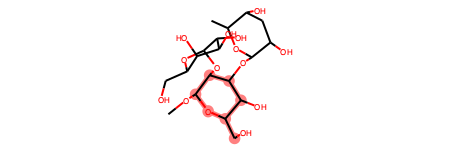

In [6]:
molREFRC

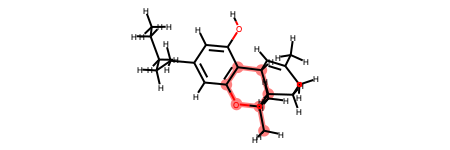

In [7]:
molPROBE

In [8]:
fixer = PDBFixer(PDB_DIR + id_1MFA + '_apo.pdb')
fixer.findMissingResidues()
fixer.findNonstandardResidues()
fixer.replaceNonstandardResidues()
fixer.removeHeterogens(True)
fixer.findMissingAtoms()
fixer.addMissingAtoms()
fixer.addMissingHydrogens(7.0)
with open(PDB_DIR + id_1MFA + 'apo_fxd.pdb', 'w') as outfile:
    PDBFile.writeFile(fixer.topology, fixer.positions, outfile)

In [9]:
molSMI = Chem.MolToSmiles(molPROBE, isomericSmiles=True)
molLIG = PDBFile('structures/pdb/PROBE_lig.pdb')
molAPO = PDBFile(PDB_DIR + id_1MFA + 'apo_fxd.pdb')

model = Modeller(molAPO.topology, molAPO.getPositions())
model.add(molLIG.topology, molLIG.getPositions())

In [10]:
# generator.gaff_version is gaff2
GAFFForceField = GAFFTemplateGenerator.INSTALLED_FORCEFIELDS[-1]
GAFFTemplate = GAFFTemplateGenerator(forcefield=GAFFForceField)
GAFFTemplate.add_molecules(
    Molecule.from_smiles(molSMI, allow_undefined_stereo=True))
    
forcefield = app.ForceField('amber14/protein.ff14SB.xml')
forcefield.registerTemplateGenerator(GAFFTemplate.generator)
# forcefield.registerTemplatePatch(residue, patch, ...)
system = forcefield.createSystem(model.topology)

Warning (not error because allow_undefined_stereo=True): 
Warning (not error because allow_undefined_stereo=True): 
Warning (not error because allow_undefined_stereo=True): 
Warning (not error because allow_undefined_stereo=True): 


In [11]:
with open('1mfa-HOLO.00.pdb', 'w+') as outfile:
    PDBFile.writeFile(
        model.topology, 
        model.getPositions(), 
        outfile)
pmd.load_file('1mfa-HOLO.00.pdb').visualize()

NGLWidget()

In [12]:
# Some active site and adjacent residues
mutMAT = expmut(
    wt = [50, 53, 54, 55, 56, 57, 59, 93, 95, 99],
    mt = ['HID', 'HSP', 'TYR', 'GLY'])
mutMAT = mutMAT.reshape(200, 4); print(mutMAT)

holo00 = md.load('1mfa-HOLO.00.pdb'); print(holo00)

# Create the paired mutations e.g. [('HIS', 93), ('ASN', 53), ...]
for i in range(mutMAT.shape[0]):
    mt1 = mutMAT[i,0]
    wt1 = mutMAT[i,1]
    wt2 = mutMAT[i,2]
    mt2 = mutMAT[i,3]
    for residue in holo00.top.chain(0).residues:
        ridx = int(residue.index)
        if ridx == int(wt1): residue.name = str(mt1)
        if ridx == int(wt2): residue.name = str(mt2)

holo00.save('SELEX.00.pdb')

[[&#39;HID&#39; &#39;50&#39; &#39;HID&#39; &#39;53&#39;]
 [&#39;HID&#39; &#39;54&#39; &#39;HID&#39; &#39;55&#39;]
 [&#39;HID&#39; &#39;56&#39; &#39;HID&#39; &#39;57&#39;]
 [&#39;HID&#39; &#39;59&#39; &#39;HID&#39; &#39;93&#39;]
 [&#39;HID&#39; &#39;95&#39; &#39;HID&#39; &#39;99&#39;]
 [&#39;HID&#39; &#39;50&#39; &#39;HID&#39; &#39;53&#39;]
 [&#39;HID&#39; &#39;54&#39; &#39;HID&#39; &#39;55&#39;]
 [&#39;HID&#39; &#39;56&#39; &#39;HID&#39; &#39;57&#39;]
 [&#39;HID&#39; &#39;59&#39; &#39;HID&#39; &#39;93&#39;]
 [&#39;HID&#39; &#39;95&#39; &#39;HID&#39; &#39;99&#39;]
 [&#39;HID&#39; &#39;50&#39; &#39;HID&#39; &#39;53&#39;]
 [&#39;HID&#39; &#39;54&#39; &#39;HID&#39; &#39;55&#39;]
 [&#39;HID&#39; &#39;56&#39; &#39;HID&#39; &#39;57&#39;]
 [&#39;HID&#39; &#39;59&#39; &#39;HID&#39; &#39;93&#39;]
 [&#39;HID&#39; &#39;95&#39; &#39;HID&#39; &#39;99&#39;]
 [&#39;HID&#39; &#39;50&#39; &#39;HID&#39; &#39;53&#39;]
 [&#39;HID&#39; &#39;54&#39; &#39;HID&#39; &#39;55&#39;]
 [&#39;HID&#39; &#39;56&#39; &#

ValueError: invalid literal for int() with base 10: &#39;HID&#39;

In [13]:

holo00 = md.load('1mfa-HOLO.00.pdb')
mut00 = md.load('SELEX.00.pdb')

mut00_df, mut00_bd = mut00.top.to_dataframe()
mut00_df_DOG = mut00_df.loc[mut00_df['resName'] == 'DOG']
mut00_df_DXP = mut00_df.loc[mut00_df['chainID'] == 0]

idx_DOG = mut00_df_DOG.resSeq.unique()
idx_DXP = mut00_df_DXP.resSeq.unique()

idx_pairs = list(it.product(idx_DOG, idx_DXP))

idx_neighs = md.compute_neighbors(mut00, 0.3, idx_DOG, idx_DXP, False)
idx_neunq = list(idx_neighs[0])

ddtraj = mut00.atom_slice(
   mut00.top.select(
        'residue ' + str(' || residue ').join([str(i) for i in idx_neunq])))
ddtraj = mut00.atom_slice(
    mut00.top.select('chainid 1'))

# gloabl_complex_rmsd = md.rmsd(holo00, mut00)
# gloabl_complex_rmsd = md.rmsd(holo01, mut01)

global_pocket_rmsd = md.rmsd(ddtraj, ddtraj)

plt.figure()
plt.legend
plt.title('RMSD')
plt.xlabel('Frame (x.x ns/frame)')
plt.ylabel('RMSD (nm)')
plt.plot(global_pocket_rmsd)
plt.savefig('1.png', dpi=300)

OSError: No such file: SELEX.00.pdb

In [ ]:
ddpocket = md.compute_distances(
    traj=mut_traj, 
    atom_pairs=list(
        it.product(
            mut_df_DOG.serial, 
            mut_df_DXP.serial)))
            
pocket_rmsd = [np.mean(dd) for dd in ddpocket]

plt.figure()
plt.title('RMSD')
plt.xlabel('Frame (x.x ns/frame)')
plt.ylabel('RMSD (nm)')
plt.plot(pocket_rmsd)
plt.savefig('1.png', dpi=300)